# LSTM
An introduction to LSTM Forecasting in scalecast. The following concepts are covered:  
1. Exploratory Data Analysis  
2. Default LSTM models  
3. Adding parameters to LSTM models  
4. Adding droput to LSTM models  
5. Differencing series  
6. Forecasting with Multiple Linear Regression  
7. Model benchmarking  
8. Feature Importance  

- data: https://www.kaggle.com/datasets/rakannimer/air-passengers
- blog post: https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf
- a more in-depth look at recurrent neural nets in scalecast: https://scalecast-examples.readthedocs.io/en/latest/rnn/rnn.html

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster

In [2]:
data = pd.read_csv('AirPassengers.csv',parse_dates=['Month'])

## EDA

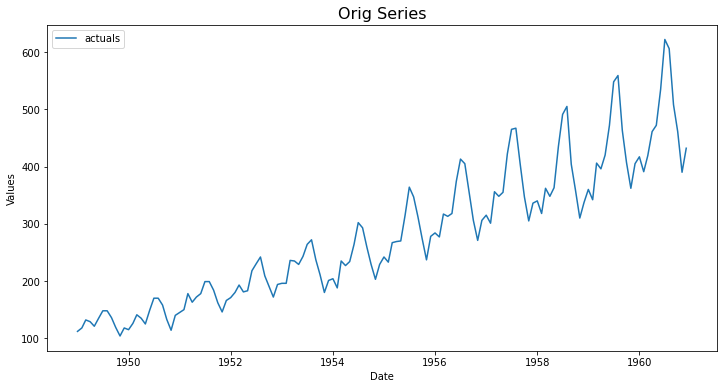

In [3]:
f = Forecaster(y=data['#Passengers'],current_dates=data['Month'])
f.plot()
plt.title('Orig Series',size=16)
plt.show()

In [4]:
f

Forecaster(
    DateStartActuals=1949-01-01T00:00:00.000000000
    DateEndActuals=1960-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=144
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

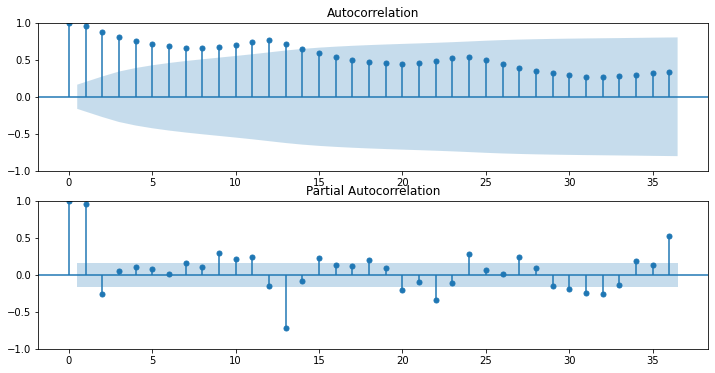

In [5]:
figs, axs = plt.subplots(2, 1,figsize=(12,6))
f.plot_acf(ax=axs[0],lags=36)
f.plot_pacf(ax=axs[1],lags=36)
plt.show()

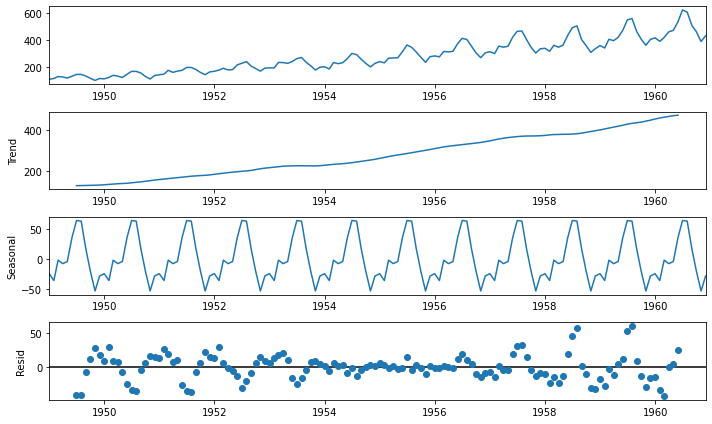

In [6]:
plt.rc("figure",figsize=(10,6))
f.seasonal_decompose().plot()
plt.show()

The below shows the results of the ADF test indicate the series is not stationary.

In [7]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: 0.82
the p-value is 0.9919
the series is not stationary
----------------------------------------------------------------------------------------------------


## Prepare Forecast for LSTM
- set test length: 12 periods
- set forecast horizon: 12 periods
- no other parameters needed for LSTM model

In [8]:
f.set_test_length(12)
f.generate_future_dates(12)

## LSTM Model

### Attempt 1
- default parameters

In [9]:
f.set_estimator('lstm')
f.manual_forecast(call_me='lstm_default')

5/5 [==============================] - 2s 2ms/step - loss: 0.3354


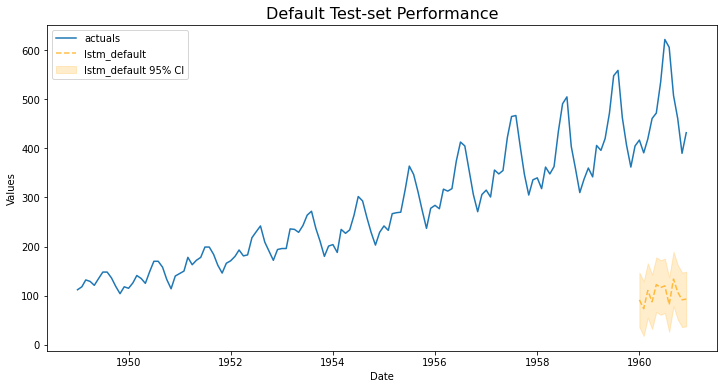

In [10]:
f.plot_test_set(ci=True)
plt.title('Default Test-set Performance',size=16)
plt.show()

### Attempt 2
- add more lags (2 years)

In [11]:
f.manual_forecast(call_me='lstm_24lags',lags=24)

4/4 [==============================] - 2s 7ms/step - loss: 0.4264


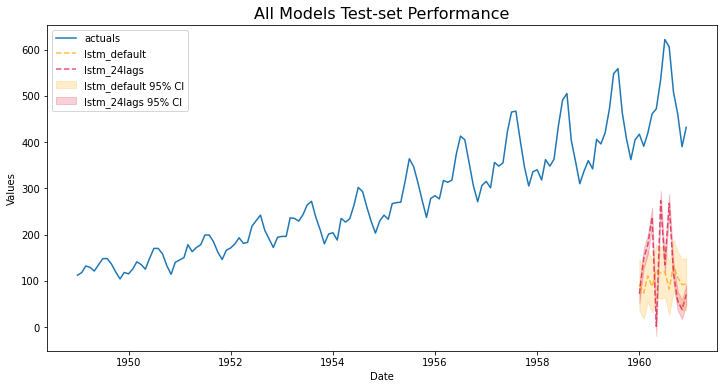

In [12]:
f.plot_test_set(ci=True)
plt.title('All Models Test-set Performance',size=16)
plt.show()

### Attempt 3
- Add more epochs (5)

In [13]:
f.manual_forecast(call_me='lstm_24lags_5epochs',lags=24,epochs=5,validation_split=.2,shuffle=True)

Epoch 1/5
3/3 [==============================] - 2s 275ms/step - loss: 0.4379 - val_loss: 0.1818
Epoch 2/5
3/3 [==============================] - 0s 18ms/step - loss: 0.4280 - val_loss: 0.1747
Epoch 3/5
3/3 [==============================] - 0s 20ms/step - loss: 0.4175 - val_loss: 0.1674
Epoch 4/5
3/3 [==============================] - 0s 17ms/step - loss: 0.4066 - val_loss: 0.1596
Epoch 5/5
3/3 [==============================] - 0s 18ms/step - loss: 0.3951 - val_loss: 0.1515
Epoch 1/5
3/3 [==============================] - 2s 233ms/step - loss: 0.4607 - val_loss: 0.1755
Epoch 2/5
3/3 [==============================] - 0s 18ms/step - loss: 0.4488 - val_loss: 0.1682
Epoch 3/5
3/3 [==============================] - 0s 20ms/step - loss: 0.4372 - val_loss: 0.1609
Epoch 4/5
3/3 [==============================] - 0s 20ms/step - loss: 0.4256 - val_loss: 0.1536
Epoch 5/5
3/3 [==============================] - 0s 18ms/step - loss: 0.4137 - val_loss: 0.1464


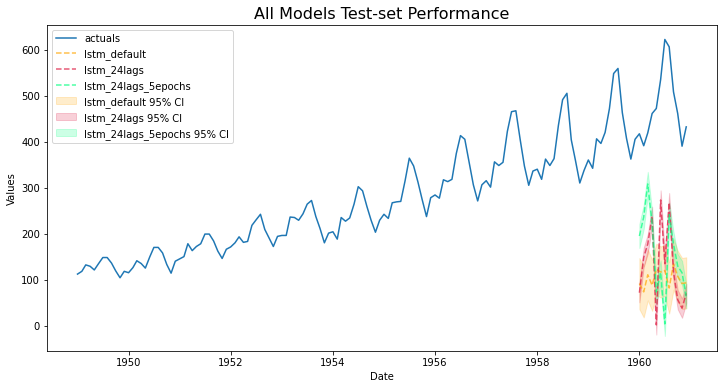

In [14]:
f.plot_test_set(ci=True)
plt.title('All Models Test-set Performance',size=16)
plt.show()

### Attempt 4
- Add layers and early stoping

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
f.manual_forecast(call_me='lstm_24lags_earlystop_3layers',
                  lags=24,
                  epochs=25,
                  validation_split=.2,
                  shuffle=True,
                  callbacks=EarlyStopping(
                      monitor='val_loss',
                      patience=5
                  ),
                  lstm_layer_sizes=(16,16,16),
                  dropout=(0,0,0))

Epoch 1/25
3/3 [==============================] - 6s 576ms/step - loss: 0.4568 - val_loss: 0.1843
Epoch 2/25
3/3 [==============================] - 0s 33ms/step - loss: 0.4380 - val_loss: 0.1677
Epoch 3/25
3/3 [==============================] - 0s 32ms/step - loss: 0.4112 - val_loss: 0.1447
Epoch 4/25
3/3 [==============================] - 0s 32ms/step - loss: 0.3729 - val_loss: 0.1289
Epoch 5/25
3/3 [==============================] - 0s 32ms/step - loss: 0.3268 - val_loss: 0.1502
Epoch 6/25
3/3 [==============================] - 0s 37ms/step - loss: 0.3005 - val_loss: 0.1798
Epoch 7/25
3/3 [==============================] - 0s 39ms/step - loss: 0.2850 - val_loss: 0.1778
Epoch 8/25
3/3 [==============================] - 0s 37ms/step - loss: 0.2596 - val_loss: 0.1512
Epoch 9/25
3/3 [==============================] - 0s 35ms/step - loss: 0.2332 - val_loss: 0.1195
Epoch 10/25
3/3 [==============================] - 0s 36ms/step - loss: 0.2158 - val_loss: 0.1002
Epoch 11/25
3/3 [===========

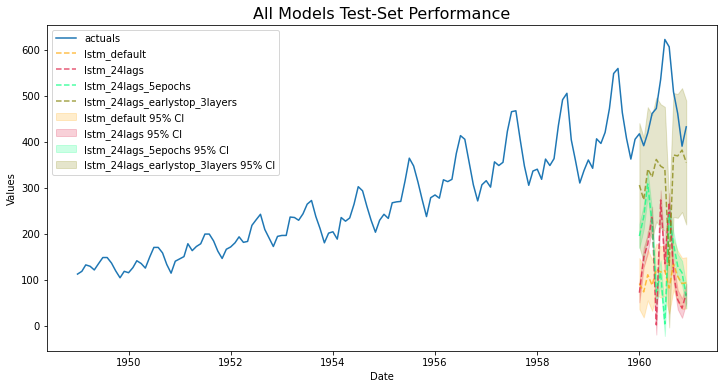

In [16]:
f.plot_test_set(ci=True)
plt.title('All Models Test-Set Performance',size=16)
plt.show()

### Attempt 5
- Add more lags (3 years)

Epoch 1/15
3/3 [==============================] - 10s 1s/step - loss: 0.4825 - val_loss: 0.2025
Epoch 2/15
3/3 [==============================] - 0s 81ms/step - loss: 0.3881 - val_loss: 0.1137
Epoch 3/15
3/3 [==============================] - 0s 78ms/step - loss: 0.2365 - val_loss: 0.1694
Epoch 4/15
3/3 [==============================] - 0s 77ms/step - loss: 0.1750 - val_loss: 0.0569
Epoch 5/15
3/3 [==============================] - 0s 81ms/step - loss: 0.1206 - val_loss: 0.0762
Epoch 6/15
3/3 [==============================] - 0s 79ms/step - loss: 0.1250 - val_loss: 0.0891
Epoch 7/15
3/3 [==============================] - 0s 79ms/step - loss: 0.1112 - val_loss: 0.0598
Epoch 8/15
3/3 [==============================] - 0s 80ms/step - loss: 0.1022 - val_loss: 0.0591
Epoch 9/15
3/3 [==============================] - 0s 80ms/step - loss: 0.0977 - val_loss: 0.0700
Epoch 10/15
3/3 [==============================] - 0s 82ms/step - loss: 0.1031 - val_loss: 0.0525
Epoch 11/15
3/3 [=============

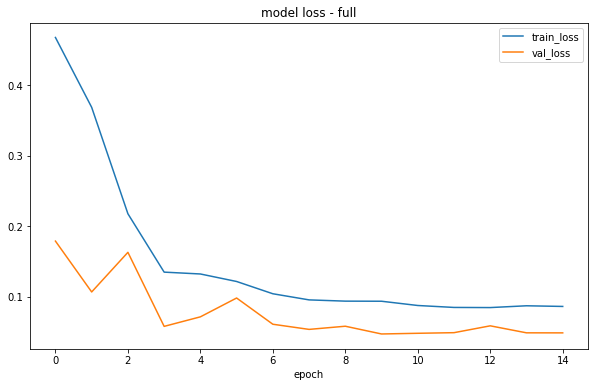

In [17]:
f.manual_forecast(call_me='lstm_24lags_4layers_15epochs',
                  lags=36,
                  batch_size=32,
                  epochs=15,
                  validation_split=.2,
                  shuffle=True,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)

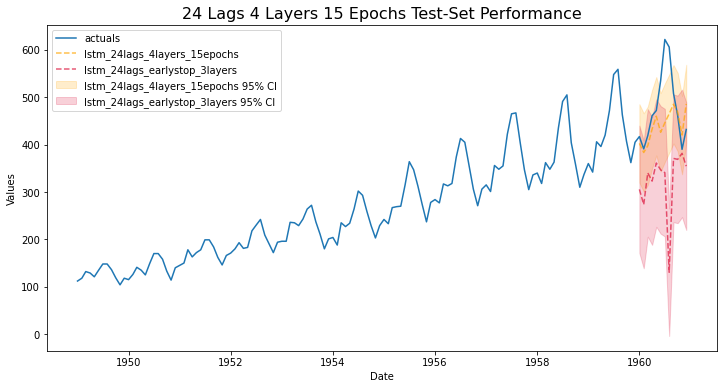

In [18]:
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2',ci=True)
plt.title('24 Lags 4 Layers 15 Epochs Test-Set Performance',size=16)
plt.show()

The last model run looks in the same ballpark as the actual series' trend, but still not great. Let's take things to the next level with this model by adding many more layers and training epochs.

### Attempt 6
- add more layers (15) and epochs (300)

Epoch 1/300
5/5 [==============================] - 35s 2s/step - loss: 0.4529 - val_loss: 0.2989
Epoch 2/300
5/5 [==============================] - 2s 322ms/step - loss: 0.1841 - val_loss: 0.1306
Epoch 3/300
5/5 [==============================] - 2s 326ms/step - loss: 0.1720 - val_loss: 0.2183
Epoch 4/300
5/5 [==============================] - 2s 314ms/step - loss: 0.1521 - val_loss: 0.1649
Epoch 5/300
5/5 [==============================] - 2s 320ms/step - loss: 0.1410 - val_loss: 0.3221
Epoch 6/300
5/5 [==============================] - 2s 323ms/step - loss: 0.1487 - val_loss: 0.2052
Epoch 7/300
5/5 [==============================] - 2s 320ms/step - loss: 0.1383 - val_loss: 0.1857
Epoch 8/300
5/5 [==============================] - 2s 397ms/step - loss: 0.1348 - val_loss: 0.2371
Epoch 9/300
5/5 [==============================] - 2s 370ms/step - loss: 0.1327 - val_loss: 0.1481
Epoch 10/300
5/5 [==============================] - 2s 314ms/step - loss: 0.1259 - val_loss: 0.0803
Epoch 11/30

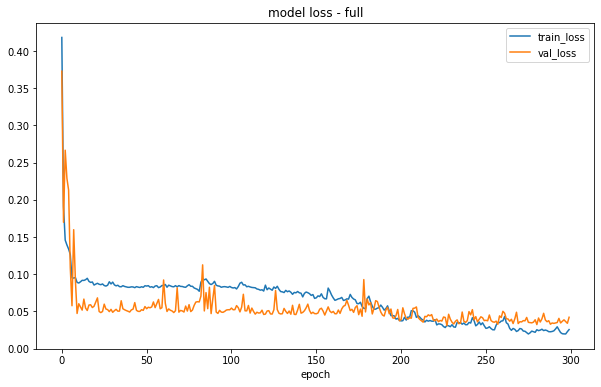

In [19]:
f.manual_forecast(call_me='lstm_best',
                  lags=36,
                  batch_size=16,
                  epochs=300,
                  validation_split=.2,
                  shuffle=True,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(100,)*15,
                  dropout=(0,)*15,
                  plot_loss=True)

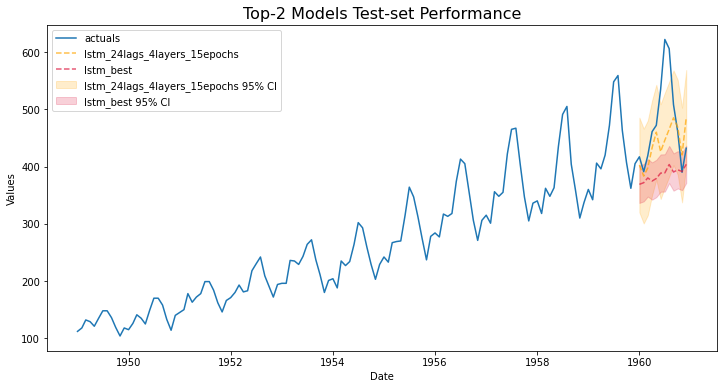

In [20]:
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2',ci=True)
plt.title('Top-2 Models Test-set Performance',size=16)
plt.show()

Finally, an LSTM model that looks somewhat believable, but it took a lot of work and took a long time to evaluate. Let's see if we can outpace this performance with a simple linear regression model.

## Prepare Forecast for MLR
- Test length already set
- Forecast horizon already set
- Add lags (24) - for MLR, these are added as regressors, not specified when calling the model (unlike LSTM)
- Add seasonal regressors (month, quarter - using dummy vars)
- Add year variable
- Add time trend
- Difference data since it is not stationary

In [21]:
f.add_ar_terms(24)
f.add_seasonal_regressors('month','quarter',dummy=True)
f.add_seasonal_regressors('year')
f.add_time_trend()
f.diff()

## MLR Modeling

In [22]:
f.set_estimator('mlr')
f.manual_forecast()

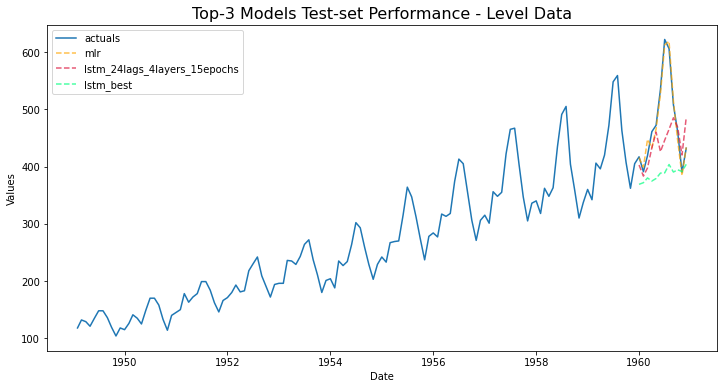

In [23]:
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_3')
plt.title('Top-3 Models Test-set Performance - Level Data',size=16)
plt.show()

It is obvious that with much less work, we find a significantly better model. LSTM is not always suited for small datasets.

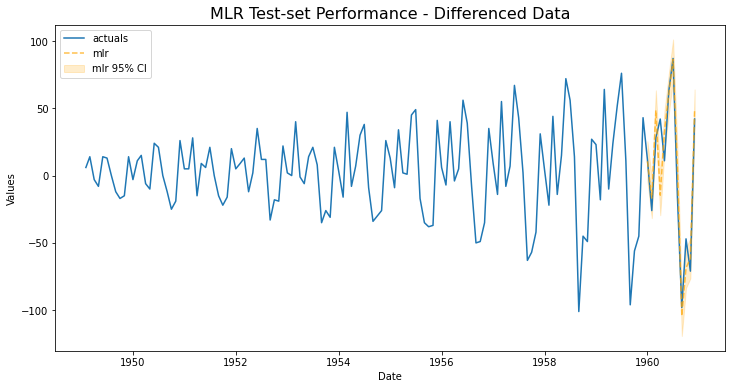

In [24]:
f.plot_test_set(models='mlr',ci=True)
plt.title('MLR Test-set Performance - Differenced Data',size=16)
plt.show()

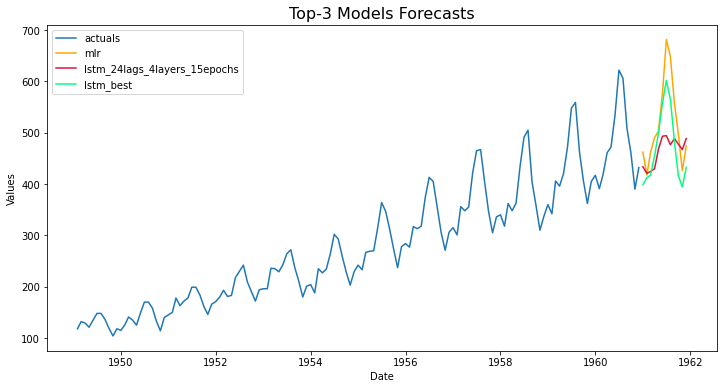

In [25]:
f.plot(order_by='LevelTestSetMAPE',models='top_3')
plt.title('Top-3 Models Forecasts',size=16)
plt.show()

## Benchmarking

In [26]:
f.export('model_summaries',determine_best_by='LevelTestSetMAPE')[
    ['ModelNickname','LevelTestSetMAPE','LevelTestSetRMSE','LevelTestSetR2','best_model']
]

,ModelNickname,LevelTestSetMAPE,LevelTestSetRMSE,LevelTestSetR2,best_model
0,mlr,0.023420,13.932124,0.964960,True
1,lstm_24lags_4layers_15epochs,0.097880,75.694382,-0.034329,False
2,lstm_best,0.172371,114.057126,-1.348424,False
3,lstm_24lags_earlystop_3layers,0.295747,190.955245,-5.582560,False
4,lstm_24lags_5epochs,0.655386,344.433224,-20.416164,False
5,lstm_24lags,0.727196,353.572014,-21.567704,False
6,lstm_default,0.782393,380.235493,-25.099784,False


## Export Results

### Export forecasts

In [27]:
f.export_forecasts_with_cis('mlr')

AttributeError: 'Forecaster' object has no attribute 'export_forecasts_with_cis'

In [ ]:
f.export_forecasts_with_cis('lstm_best')

### Export test-set preds

In [ ]:
f.export_test_set_preds_with_cis('mlr')

In [ ]:
f.export_test_set_preds_with_cis('lstm_best')

### Export Feature Info
- For MLR only

In [ ]:
f.save_feature_importance()
f.export_feature_importance('mlr')